In [1]:
import os
import glob
import datetime
import numpy as np
import pandas as pd
import xarray as xr

from osgeo import gdal
#from gistool import rasterize
import pyhdf
from pyhdf.SD import SD
import geopandas as gpd

from scipy import stats
from scipy import integrate
from numpy import exp
import math
from pymannkendall import original_test as mk

import matplotlib as mpl
import matplotlib.pyplot as plt
## set the line width of the hatch
mpl.rcParams['hatch.linewidth'] = 0.5
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter,LatitudeFormatter
import matplotlib.ticker as mticker

## pre

In [2]:
a0 = xr.open_dataset('/portal1/dell/li-b/MODIS1/lai_qc_0.05p0.nc')
a1 = xr.open_dataset('/portal1/dell/li-b/MODIS1/lai_qc_0.05p1.nc')
a2 = xr.open_dataset('/portal1/dell/li-b/MODIS1/lai_qc_0.05p2.nc')
a3 = xr.open_dataset('/portal1/dell/li-b/MODIS1/lai_qc_0.05p3.nc')

ds0 = xr.concat([a0,a1,a2,a3], dim='time')
ds0

/home/li-b/.conda/envs/lbn/lib/python3.10/site-packages/xarray/core/concat.py:544: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


<xarray.Dataset>
Dimensions:  (time: 941, lat: 190, lon: 231)
Coordinates:
  * time     (time) object 2002-07-04 00:00:00 ... 2022-12-27 00:00:00
  * lat      (lat) float64 33.98 33.93 33.88 33.83 ... 24.68 24.63 24.58 24.53
  * lon      (lon) float64 110.5 110.6 110.6 110.7 ... 121.9 121.9 122.0 122.0
Data variables:
    vari     (time, lat, lon) float64 2.5 2.7 3.1 5.1 1.7 ... nan nan nan nan

In [14]:
ds0.to_netcdf('/portal1/dell/li-b/MODIS1/lai_qc_0.05.nc')

## area-mean

In [2]:
ds0 = xr.open_dataset('/portal1/dell/li-b/MODIS1/lai_qc_0.05.nc')

# exclude taiwan(120.5,122)(24.5,25.5)   i>=85 and j>=100 for 0.1 deg  i>=2040 and j>=2400 for 500m
arr = ds0['vari'].values
lats = ds0.lat.values
lons = ds0.lon.values

for i in range(0,len(lats)):
    for j in range(0,len(lons)):
        if i>=169 and j>=200:
            arr[:,i,j] = np.nan
        else:
            continue

ds00 = xr.Dataset({'vari': (['time','lat','lon'], arr)},
                      coords={'time': (['time'], ds0.time.values), 
                              'lat': (['lat'], ds0.lat.values),
                      'lon': (['lon'], ds0.lon.values),})

ds000 = ds00['vari'].resample(time='D').pad().to_dataset()
ds1 = ds000['vari'].resample(time='M').mean(skipna=True).to_dataset()

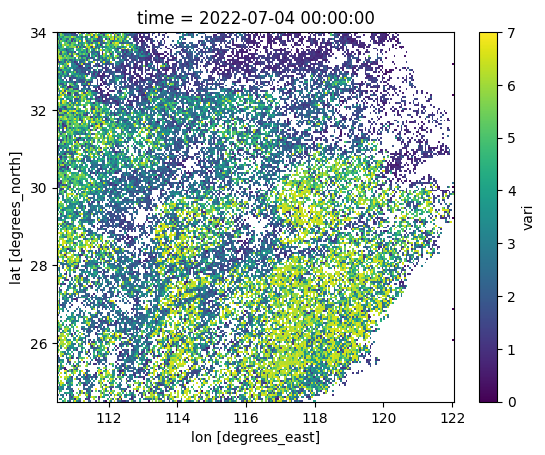

In [3]:
ds0['vari'].sel(time='2022-07-04').plot()

In [3]:
ds_m0 = ds1.sel(time=ds1['time.month'].isin([7]))
ds_m = ds_m0['vari'].values

anos = np.zeros_like(ds_m)

for i in range(0,ds_m.shape[2]):
    for j in range(0,ds_m.shape[1]):
        v1 = ds_m[:,j,i]
        date = np.arange(2002,2023)
        
        non_nan_count = np.count_nonzero(~np.isnan(v1))
        if non_nan_count > 1:
            tr = mk(v1, alpha=0.05).trend
            if tr=='increasing':
                pvalue=1
                slo = stats.linregress(date,v1).slope
                interc = stats.linregress(date,v1).intercept
                trend = slo*date + interc
                anos[:,j,i] = v1 - trend
            elif tr=='decreasing':
                pvalue=-1
                slo = stats.linregress(date,v1).slope
                interc = stats.linregress(date,v1).intercept
                trend = slo*date + interc
                anos[:,j,i] = v1 - trend
            elif tr=='no trend':
                pvalue=np.nan
                anos[:,j,i] = v1 - v1.mean()
        else:
            anos[:,j,i] = v1 - v1.mean()
            
ds_ano7 = xr.Dataset({'vari': (['time','lat','lon'], anos)},
                      coords={'time': (['time'], ds_m0.time.values), 
                              'lat': (['lat'], ds_m0.lat.values),
                      'lon': (['lon'], ds_m0.lon.values),})
##################################################################################################
ds_m0 = ds1.sel(time=ds1['time.month'].isin([8]))
ds_m = ds_m0['vari'].values

anos = np.zeros_like(ds_m)

for i in range(0,ds_m.shape[2]):
    for j in range(0,ds_m.shape[1]):
        v1 = ds_m[:,j,i]
        date = np.arange(2002,2023)
        
        non_nan_count = np.count_nonzero(~np.isnan(v1))
        if non_nan_count > 1:
            tr = mk(v1, alpha=0.05).trend
            if tr=='increasing':
                pvalue=1
                slo = stats.linregress(date,v1).slope
                interc = stats.linregress(date,v1).intercept
                trend = slo*date + interc
                anos[:,j,i] = v1 - trend
            elif tr=='decreasing':
                pvalue=-1
                slo = stats.linregress(date,v1).slope
                interc = stats.linregress(date,v1).intercept
                trend = slo*date + interc
                anos[:,j,i] = v1 - trend
            elif tr=='no trend':
                pvalue=np.nan
                anos[:,j,i] = v1 - v1.mean()
        else:
            anos[:,j,i] = v1 - v1.mean()
            
ds_ano8 = xr.Dataset({'vari': (['time','lat','lon'], anos)},
                      coords={'time': (['time'], ds_m0.time.values), 
                              'lat': (['lat'], ds_m0.lat.values),
                      'lon': (['lon'], ds_m0.lon.values),})
##############################################################################################
ds_m0 = ds1.sel(time=ds1['time.month'].isin([9]))
ds_m = ds_m0['vari'].values

anos = np.zeros_like(ds_m)

for i in range(0,ds_m.shape[2]):
    for j in range(0,ds_m.shape[1]):
        v1 = ds_m[:,j,i]
        date = np.arange(2002,2023)
        
        non_nan_count = np.count_nonzero(~np.isnan(v1))
        if non_nan_count > 1:
            tr = mk(v1, alpha=0.05).trend
            if tr=='increasing':
                pvalue=1
                slo = stats.linregress(date,v1).slope
                interc = stats.linregress(date,v1).intercept
                trend = slo*date + interc
                anos[:,j,i] = v1 - trend
            elif tr=='decreasing':
                pvalue=-1
                slo = stats.linregress(date,v1).slope
                interc = stats.linregress(date,v1).intercept
                trend = slo*date + interc
                anos[:,j,i] = v1 - trend
            elif tr=='no trend':
                pvalue=np.nan
                anos[:,j,i] = v1 - v1.mean()
        else:
            anos[:,j,i] = v1 - v1.mean()
            
ds_ano9 = xr.Dataset({'vari': (['time','lat','lon'], anos)},
                      coords={'time': (['time'], ds_m0.time.values), 
                              'lat': (['lat'], ds_m0.lat.values),
                      'lon': (['lon'], ds_m0.lon.values),})
########################################################################################################
ds_m0 = ds1.sel(time=ds1['time.month'].isin([7,8,9]))
ds_m1 = ds_m0.groupby('time.year').mean(dim='time',skipna=True)
ds_m = ds_m1['vari'].values

anos = np.zeros_like(ds_m)

for i in range(0,ds_m.shape[2]):
    for j in range(0,ds_m.shape[1]):
        v1 = ds_m[:,j,i]
        date = np.arange(2002,2023)
        
        non_nan_count = np.count_nonzero(~np.isnan(v1))
        if non_nan_count > 1:
            tr = mk(v1, alpha=0.05).trend
            if tr=='increasing':
                pvalue=1
                slo = stats.linregress(date,v1).slope
                interc = stats.linregress(date,v1).intercept
                trend = slo*date + interc
                anos[:,j,i] = v1 - trend
            elif tr=='decreasing':
                pvalue=-1
                slo = stats.linregress(date,v1).slope
                interc = stats.linregress(date,v1).intercept
                trend = slo*date + interc
                anos[:,j,i] = v1 - trend
            elif tr=='no trend':
                pvalue=np.nan
                anos[:,j,i] = v1 - v1.mean()
        else:
            anos[:,j,i] = v1 - v1.mean()
            
ds_ano789 = xr.Dataset({'vari': (['time','lat','lon'], anos)},
                      coords={'time': (['time'], ds_ano7.time.values), 
                              'lat': (['lat'], ds_m0.lat.values),
                      'lon': (['lon'], ds_m0.lon.values),})

/home/li-b/.conda/envs/lbn/lib/python3.10/site-packages/xarray/core/concat.py:544: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


In [4]:
c7 = ds_ano7['vari'].mean(dim=['lat','lon'],skipna=True).values
c8 = ds_ano8['vari'].mean(dim=['lat','lon'],skipna=True).values
c9 = ds_ano9['vari'].mean(dim=['lat','lon'],skipna=True).values
c789 = ds_ano789['vari'].mean(dim=['lat','lon'],skipna=True).values
times = pd.date_range('2002','2023',freq='Y')
df1 = pd.DataFrame({'time':times,'jul_ano':c7,'agu_ano':c8,'sep_ano':c9,'jas_ano':c789})
df1

,time,jul_ano,agu_ano,sep_ano,jas_ano
0,2002-12-31,-0.020413,-0.061877,-0.168426,-0.069832
1,2003-12-31,-0.116133,-0.278382,-0.009665,-0.121345
2,2004-12-31,0.082491,-0.135479,-0.155793,-0.059149
3,2005-12-31,-0.090112,-0.132977,-0.001636,-0.066151
4,2006-12-31,-0.104782,0.120009,-0.008402,0.009801
5,2007-12-31,0.036379,0.029424,-0.000256,0.026336
6,2008-12-31,-0.000911,-0.003749,-0.036698,-0.009953
7,2009-12-31,-0.071139,0.061198,-0.100689,-0.033728
8,2010-12-31,-0.160171,0.108419,0.104918,0.019048
9,2011-12-31,0.009457,0.087533,-0.047994,0.016394


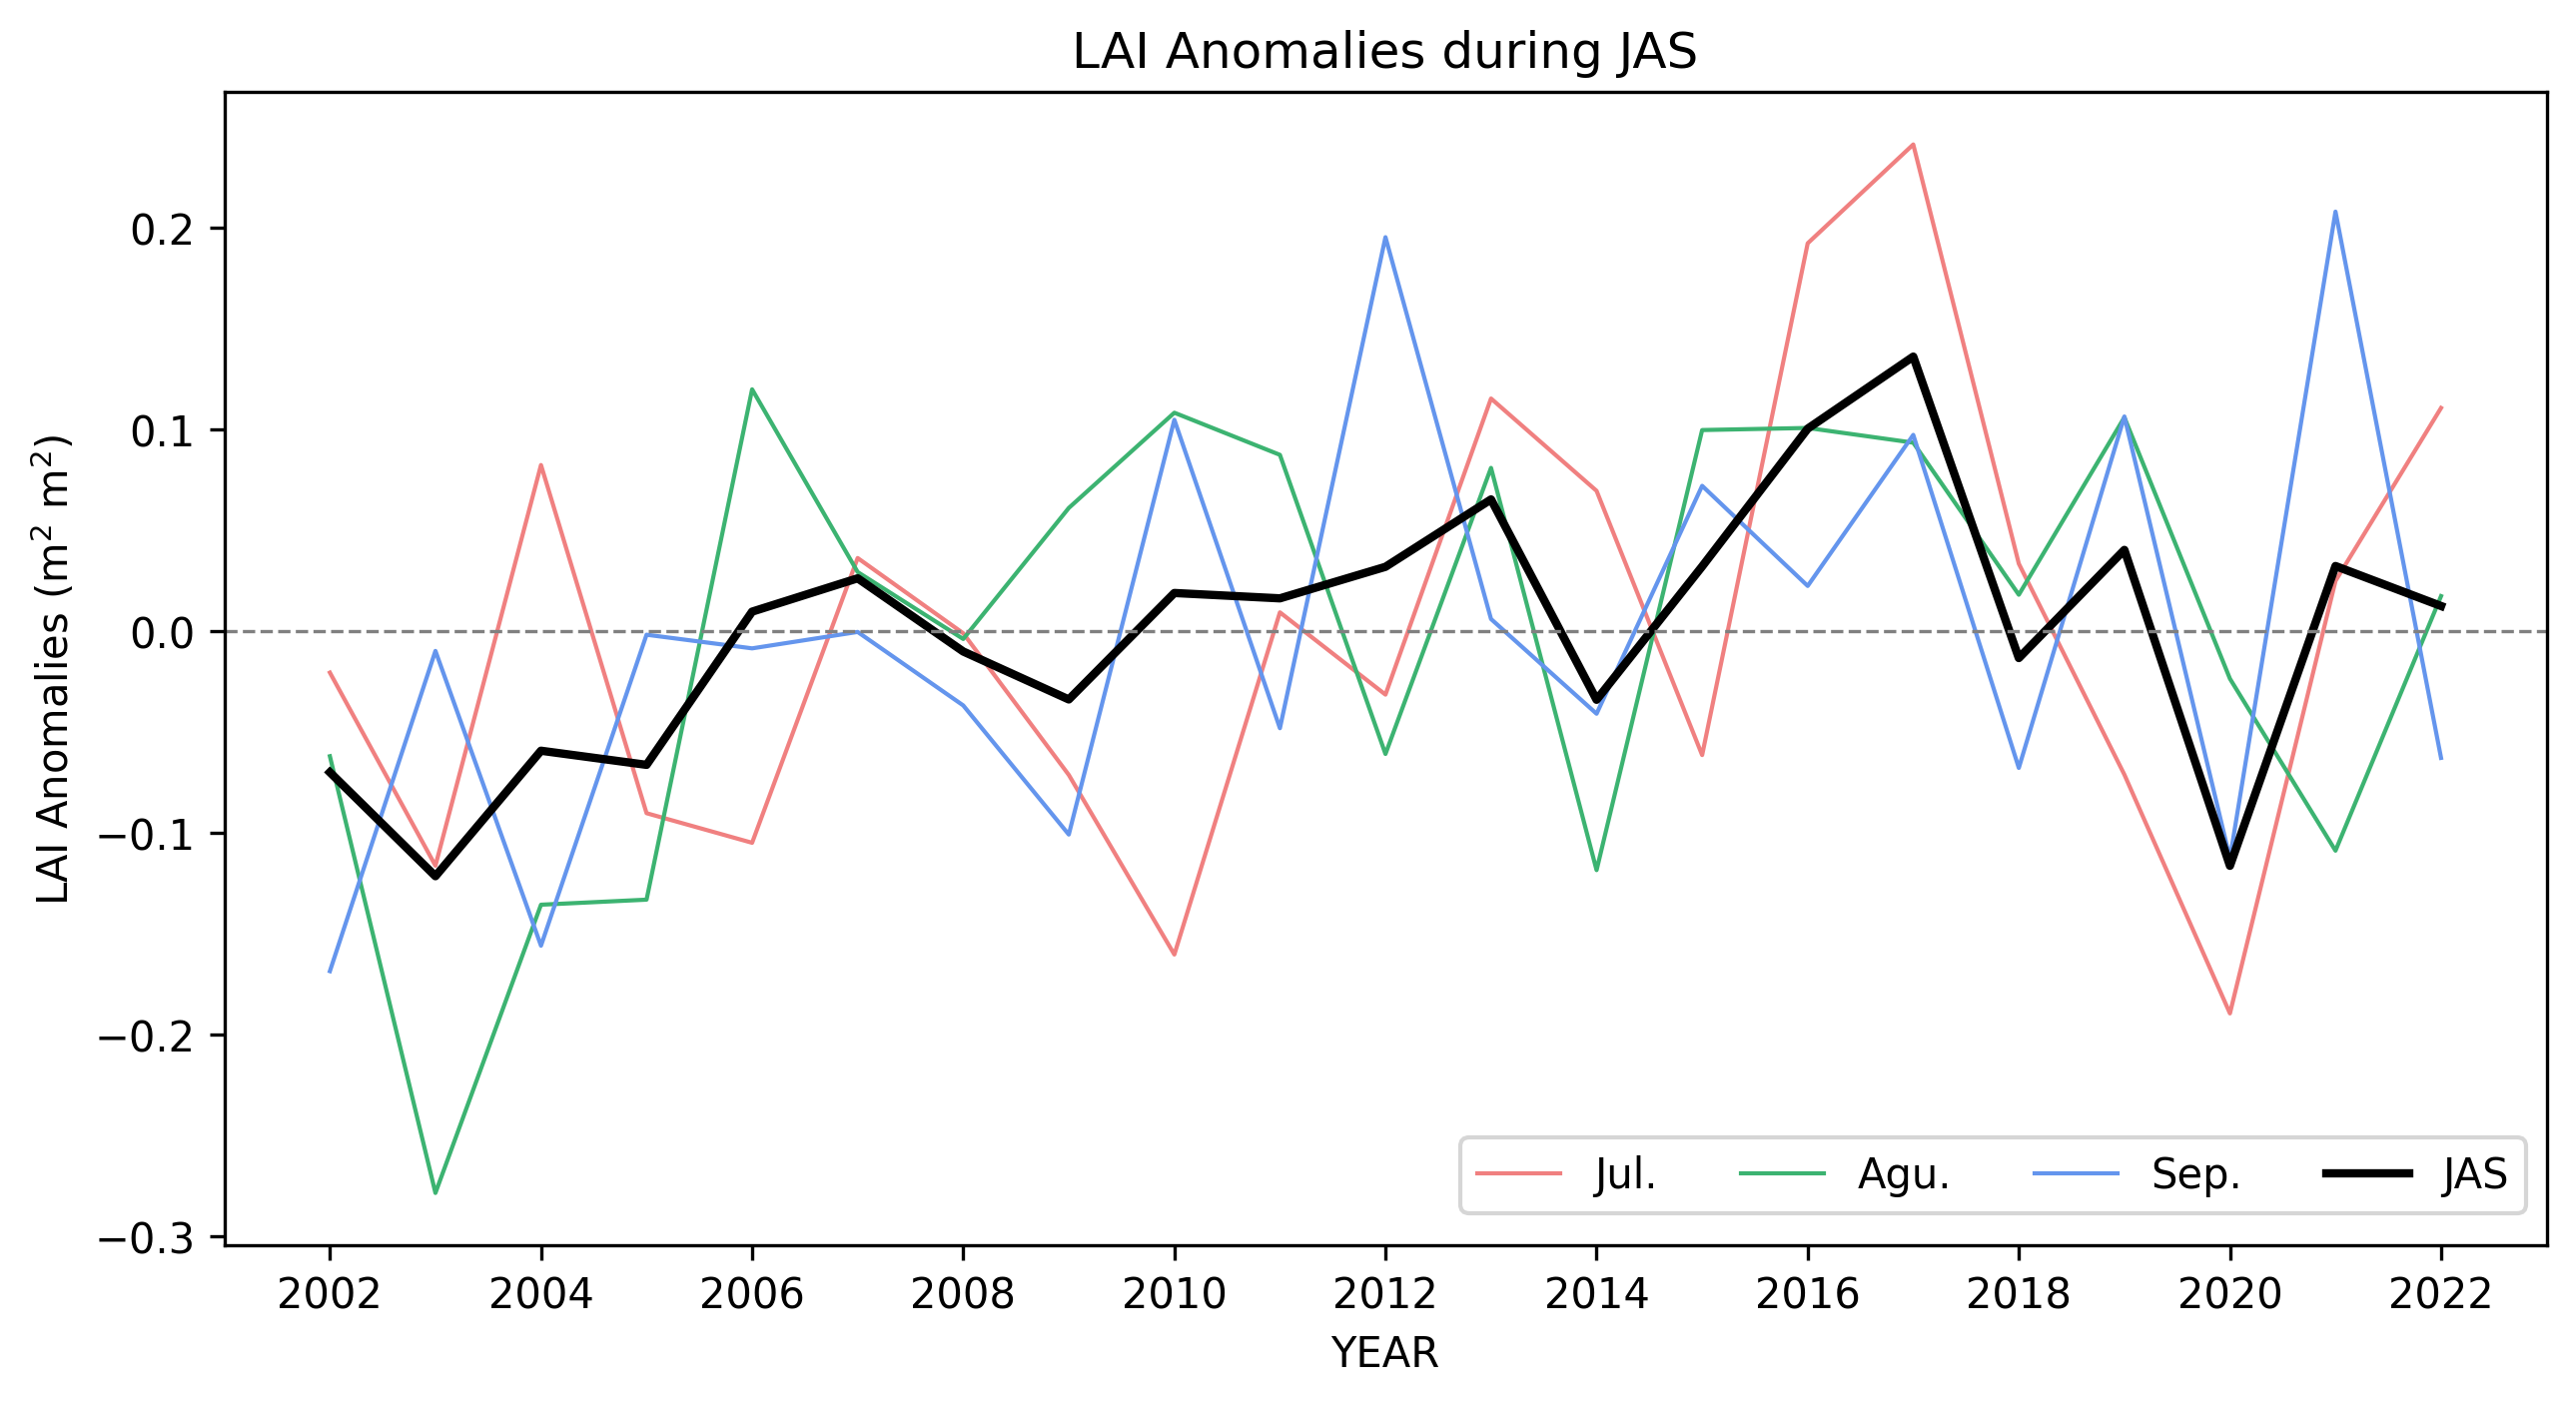

In [5]:
date = np.arange(2002,2023)
v1 = df1['jul_ano']
v2 = df1['agu_ano']
v3 = df1['sep_ano']
v4 = df1['jas_ano']

fig, ax = plt.subplots(1,1,dpi=300,figsize=(10,5))


ax.plot(date, v1,color='lightcoral',lw=1, ls='-', label='Jul.')
ax.plot(date, v2,color='mediumseagreen',lw=1, ls='-', label='Agu.')
ax.plot(date, v3,color='cornflowerblue',lw=1, ls='-', label='Sep.')
ax.plot(date, v4,color='black',lw=2, ls='-', label='JAS')

ax.set_ylabel('LAI Anomalies (m$^2$ m${^2}$)')
#ax1.set_ylabel('PRR (%)')
ax.set_xlabel('YEAR')
custom_ticks = np.arange(2002, 2023, step=2)  # Define the tick locations
custom_tick_labels = [str(year) for year in custom_ticks]  # Define the tick labels

ax.set_xticks(custom_ticks)
ax.set_xticklabels(custom_tick_labels)

ax.axhline(y=0, color='gray', linestyle='--',lw=0.8)
    
#figname = filename.replace('.txt','')
ax.set_title('LAI Anomalies during JAS')
ax.set_xlim(date[0]-1, date[-1]+1)
fig.legend(loc="lower right", bbox_to_anchor=(1, 0.01), bbox_transform=ax.transAxes, ncol = 5)

#plt.savefig('D:/rice/figs/middleyield.png')                         
plt.show()

In [24]:
mask = xr.open_dataset('/portal1/dell/li-b/LC_IGBP_2022_epsg4326.tif')

x = ds_ano789.dims['lon']
y = ds_ano789.dims['lat']

qc_a = mask['band_data'].sel(band=1).values
qc_b = np.zeros((y, x), dtype=bool)
qc_b = (qc_a == 1) | (qc_a == 2) | (qc_a == 4) | (qc_a == 5) 


vari_a = ds_ano789['vari'][20,:,:].values
vari_b = np.zeros((y, x))
vari_b = np.where(qc_b, vari_a, np.nan)
print('forest', np.nanmean(vari_b))

x = ds_ano789.dims['lon']
y = ds_ano789.dims['lat']

qc_a = mask['band_data'].sel(band=1).values
qc_b = np.zeros((y, x), dtype=bool)
qc_b = (qc_a == 8) | (qc_a == 9) | (qc_a == 10)


vari_a = ds_ano789['vari'][20,:,:].values
vari_b = np.zeros((y, x))
vari_b = np.where(qc_b, vari_a, np.nan)
print('savanna', np.nanmean(vari_b))

x = ds_ano789.dims['lon']
y = ds_ano789.dims['lat']

qc_a = mask['band_data'].sel(band=1).values
qc_b = np.zeros((y, x), dtype=bool)
qc_b = (qc_a == 12) | (qc_a == 14)


vari_a = ds_ano789['vari'][20,:,:].values
vari_b = np.zeros((y, x))
vari_b = np.where(qc_b, vari_a, np.nan)
print('crop', np.nanmean(vari_b))

forest 0.2151747527429426
savanna -0.053141806814135814
crop -0.025882462025231145


In [17]:
# from datetime import datetime
# times = ds000.time.values
# times1 = []
# for t in times:
#     t1 = datetime.strptime(str(t),'%Y-%m-%d %H:%M:%S')
#     t2 = pd.to_datetime(t1)
#     times1.append(t2)
# times1 = np.array(times1)

# area = ds000['vari'].mean(dim=['lat','lon'],skipna=True).values
# df_8d = pd.DataFrame({'time':times1,'vari':area})
# df_8d.set_index('time',inplace=True)
# df_8d1 = df_8d.resample('D').asfreq().fillna(method='ffill')
# df_8d1

/tmp/ipykernel_189121/1191135384.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_8d1 = df_8d.resample('D').asfreq().fillna(method='ffill')


,vari
time,
2002-07-04,3.038739
2002-07-05,3.038739
2002-07-06,3.038739
2002-07-07,3.038739
2002-07-08,3.038739
...,...
2022-12-23,1.388049
2022-12-24,1.388049
2022-12-25,1.388049


In [16]:
# from datetime import datetime
# times = ds000.time.values
# times1 = []
# for t in times:
#     t1 = datetime.strptime(str(t),'%Y-%m-%d %H:%M:%S')
#     t2 = pd.to_datetime(t1)
#     times1.append(t2)
# times1 = np.array(times1)

# area = ds000['vari'].mean(dim=['lat','lon'],skipna=True).values
# df_8d = pd.DataFrame({'time':times1,'vari':area})
# df_8d
# # df_8d.set_index('time',inplace=True)
# # df_8d1 = df_8d.resample('D').asfreq().fillna(method='ffill')
# # df_m = df_8d1.resample('M').mean()
# # df_m

,time,vari
0,2002-07-04,3.038739
1,2002-07-05,3.038739
2,2002-07-06,3.038739
3,2002-07-07,3.038739
4,2002-07-08,3.038739
...,...,...
7477,2022-12-23,1.388049
7478,2022-12-24,1.388049
7479,2022-12-25,1.388049
7480,2022-12-26,1.388049


In [12]:
# area = ds1['vari'].mean(dim=['lat','lon'],skipna=True).values
# times = pd.date_range('2002-07-31', '2022-12-31', freq='M')
# df = pd.DataFrame({'time':times,'vari':area})
# df.set_index('time',inplace=True)

# df_7 = df['vari'].loc[df.index.month==7].values
# df_8 = df['vari'].loc[df.index.month==8].values
# df_9 = df['vari'].loc[df.index.month==9].values
# times = pd.date_range('2002','2023',freq='Y')

# df1 = pd.DataFrame({'time':times,'jul':df_7,'agu':df_8,'sep':df_9})
# df1['jas'] = (df1['jul'] + df1['agu'] + df1['sep'])/3
# df1.set_index('time',inplace=True)

# date = np.arange(2002,2023)
# results = {}

# for column in df1.columns:
#     v1 = df1[column].values
    
#     tr = mk(v1, alpha=0.05).trend
#     if tr=='increasing':
#         pvalue=1
#         slo = stats.linregress(date,v1).slope
#         interc = stats.linregress(date,v1).intercept
#         trend = slo*date + interc
#         df1[column+'_ano'] = df1[column].values - trend
#     elif tr=='decreasing':
#         pvalue=-1
#         slo = stats.linregress(date,v1).slope
#         interc = stats.linregress(date,v1).intercept
#         trend = slo*date + interc
#         df1[column+'_ano'] = df1[column].values - trend
#     elif tr=='no trend':
#         pvalue=np.nan
#         df1[column+'_ano'] = df1[column].values - df1[column].values.mean() 
    
#     results[column] = (slo, pvalue)
# results

{'jul': (0.01195805190199713, 1),
 'agu': (0.009654776311461982, 1),
 'sep': (0.018797163472336547, 1),
 'jas': (0.01346999722859856, 1)}

## spatial

In [9]:
d7_0 = ds_ano7['vari'].sel(time='2022-07-31').values
box7 = d7_0[~np.isnan(d7_0)].ravel()

d8_0 = ds_ano8['vari'].sel(time='2022-08-31').values
box8 = d8_0[~np.isnan(d8_0)].ravel()

d9_0 = ds_ano9['vari'].sel(time='2022-09-30').values
box9 = d9_0[~np.isnan(d9_0)].ravel()

d789_0 = ds_ano789['vari'].sel(time='2022-07-31').values
box789 = d789_0[~np.isnan(d789_0)].ravel()

box = [box7,box8,box9,box789]
for i in box:
    lo = np.nanpercentile(i,q=25)
    up = np.nanpercentile(i,q=75)
    upbo = up+1.5*(up-lo)
    lobo = lo-1.5*(up-lo)
    maxmum = i.max()
    minmum = i.min()
    print(upbo, lobo, maxmum, minmum)

1.3386949783901347 -1.128114240605769 3.6663951843726954 -3.3096181736300627
1.2585303125852139 -1.239332650840872 3.788052506473291 -3.2917082292152595
1.0804705477989174 -1.2373444917917134 2.713522557309755 -3.0102089547122253
0.9263150024484735 -0.924759706074498 2.1502768570971824 -2.440101513996777


/home/li-b/.conda/envs/lbn/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/li-b/.conda/envs/lbn/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


Text(0.5, 1.0, '2022 Jul. LAI Anomalies')

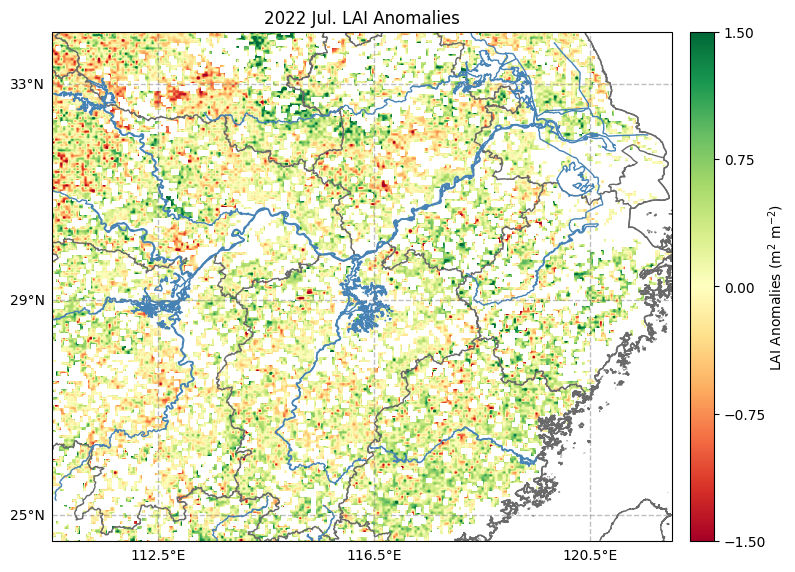

In [16]:
data = ds_ano7['vari'][20,:,:].values
gdf1 = gpd.read_file('/portal1/dell/li-b/meteo/bound.shp')
gdf2 = gpd.read_file('/portal1/dell/li-b/meteo/allrivers.shp')
latitude, longitude = ds_ano7.lat.values, ds_ano7.lon.values

vmax=1.5
vmin=-1.5
cmap = plt.get_cmap('RdYlGn')

projection = ccrs.PlateCarree()
# arr_flipped = np.flip(data, axis=0)
arr_flipped = data
fig, ax = plt.subplots(figsize=(8,10),subplot_kw={'projection': ccrs.PlateCarree()})
gdf1.plot(ax=ax, facecolor='none', edgecolor='dimgray', linewidth=1)
gdf2.plot(ax=ax, facecolor='none', edgecolor='steelblue', linewidth=1)
img = ax.imshow(arr_flipped, extent=[longitude.min(), longitude.max(), latitude.min(), latitude.max()],
                transform=projection,
                cmap=cmap,
                vmax=vmax,
                vmin=vmin)


ticks = list(np.linspace(vmin, vmax, 5))
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
pos = ax.get_position()
pad = 0.015*1.5
width = 0.015*2
clen = 0.6
cax = fig.add_axes([pos.xmax + pad, pos.ymin, width, (pos.ymax - pos.ymin)])
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, extend='neither', orientation='vertical')
cbar.ax.set_ylabel('LAI Anomalies (m$^2$ m$^{-2}$)')
cbar.set_ticks(ticks)
# Adjust the distance between colorbar label and colorbar
labelpad = 0.001  # Adjust this value as needed
cbar.ax.yaxis.labelpad = labelpad

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlocator = mticker.FixedLocator([112.5,116.5,120.5])
gl.ylocator = mticker.FixedLocator([25,29,33])

ax.set_title('2022 Jul. LAI Anomalies')

/home/li-b/.conda/envs/lbn/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/li-b/.conda/envs/lbn/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


Text(0.5, 1.0, '2022 Agu. LAI Anomalies')

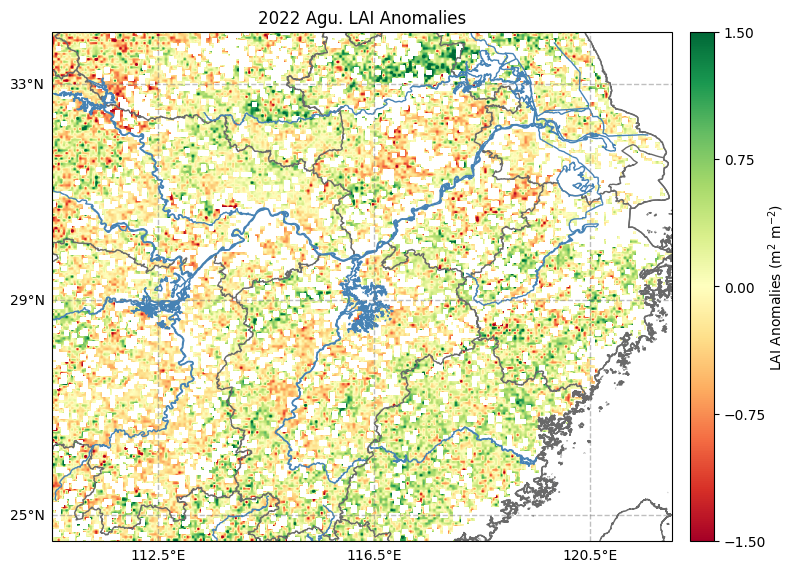

In [17]:
data = ds_ano8['vari'][20,:,:].values
gdf1 = gpd.read_file('/portal1/dell/li-b/meteo/bound.shp')
gdf2 = gpd.read_file('/portal1/dell/li-b/meteo/allrivers.shp')
latitude, longitude = ds_ano7.lat.values, ds_ano7.lon.values

vmax=1.5
vmin=-1.5
cmap = plt.get_cmap('RdYlGn')

projection = ccrs.PlateCarree()
# arr_flipped = np.flip(data, axis=0)
arr_flipped = data
fig, ax = plt.subplots(figsize=(8,10),subplot_kw={'projection': ccrs.PlateCarree()})
gdf1.plot(ax=ax, facecolor='none', edgecolor='dimgray', linewidth=1)
gdf2.plot(ax=ax, facecolor='none', edgecolor='steelblue', linewidth=1)
img = ax.imshow(arr_flipped, extent=[longitude.min(), longitude.max(), latitude.min(), latitude.max()],
                transform=projection,
                cmap=cmap,
                vmax=vmax,
                vmin=vmin)


ticks = list(np.linspace(vmin, vmax, 5))
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
pos = ax.get_position()
pad = 0.015*1.5
width = 0.015*2
clen = 0.6
cax = fig.add_axes([pos.xmax + pad, pos.ymin, width, (pos.ymax - pos.ymin)])
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, extend='neither', orientation='vertical')
cbar.ax.set_ylabel('LAI Anomalies (m$^2$ m$^{-2}$)')
cbar.set_ticks(ticks)
# Adjust the distance between colorbar label and colorbar
labelpad = 0.001  # Adjust this value as needed
cbar.ax.yaxis.labelpad = labelpad

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlocator = mticker.FixedLocator([112.5,116.5,120.5])
gl.ylocator = mticker.FixedLocator([25,29,33])

ax.set_title('2022 Agu. LAI Anomalies')

/home/li-b/.conda/envs/lbn/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/li-b/.conda/envs/lbn/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


Text(0.5, 1.0, '2022 Sep. LAI Anomalies')

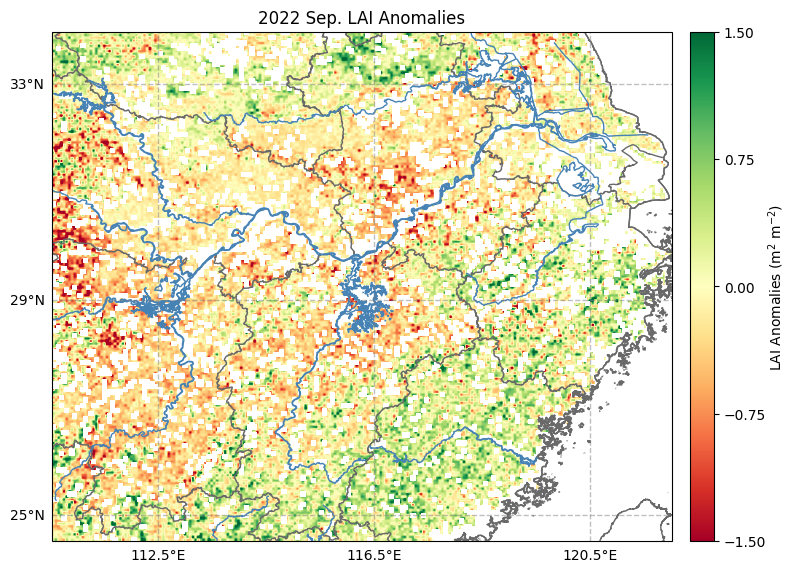

In [18]:
data = ds_ano9['vari'][20,:,:].values
gdf1 = gpd.read_file('/portal1/dell/li-b/meteo/bound.shp')
gdf2 = gpd.read_file('/portal1/dell/li-b/meteo/allrivers.shp')
latitude, longitude = ds_ano7.lat.values, ds_ano7.lon.values

vmax=1.5
vmin=-1.5
cmap = plt.get_cmap('RdYlGn')

projection = ccrs.PlateCarree()
# arr_flipped = np.flip(data, axis=0)
arr_flipped = data
fig, ax = plt.subplots(figsize=(8,10),subplot_kw={'projection': ccrs.PlateCarree()})
gdf1.plot(ax=ax, facecolor='none', edgecolor='dimgray', linewidth=1)
gdf2.plot(ax=ax, facecolor='none', edgecolor='steelblue', linewidth=1)
img = ax.imshow(arr_flipped, extent=[longitude.min(), longitude.max(), latitude.min(), latitude.max()],
                transform=projection,
                cmap=cmap,
                vmax=vmax,
                vmin=vmin)


ticks = list(np.linspace(vmin, vmax, 5))
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
pos = ax.get_position()
pad = 0.015*1.5
width = 0.015*2
clen = 0.6
cax = fig.add_axes([pos.xmax + pad, pos.ymin, width, (pos.ymax - pos.ymin)])
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, extend='neither', orientation='vertical')
cbar.ax.set_ylabel('LAI Anomalies (m$^2$ m$^{-2}$)')
cbar.set_ticks(ticks)
# Adjust the distance between colorbar label and colorbar
labelpad = 0.001  # Adjust this value as needed
cbar.ax.yaxis.labelpad = labelpad

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlocator = mticker.FixedLocator([112.5,116.5,120.5])
gl.ylocator = mticker.FixedLocator([25,29,33])

ax.set_title('2022 Sep. LAI Anomalies')

/home/li-b/.conda/envs/lbn/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/li-b/.conda/envs/lbn/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


Text(0.5, 1.0, '2022 JAS LAI Anomalies')

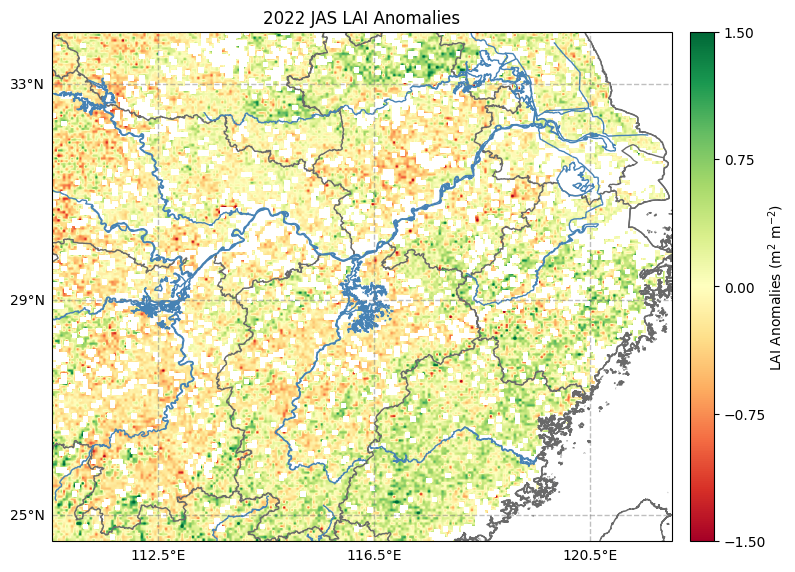

In [19]:
data = ds_ano789['vari'][20,:,:].values
gdf1 = gpd.read_file('/portal1/dell/li-b/meteo/bound.shp')
gdf2 = gpd.read_file('/portal1/dell/li-b/meteo/allrivers.shp')
latitude, longitude = ds_ano7.lat.values, ds_ano7.lon.values

vmax=1.5
vmin=-1.5
cmap = plt.get_cmap('RdYlGn')

projection = ccrs.PlateCarree()
# arr_flipped = np.flip(data, axis=0)
arr_flipped = data
fig, ax = plt.subplots(figsize=(8,10),subplot_kw={'projection': ccrs.PlateCarree()})
gdf1.plot(ax=ax, facecolor='none', edgecolor='dimgray', linewidth=1)
gdf2.plot(ax=ax, facecolor='none', edgecolor='steelblue', linewidth=1)
img = ax.imshow(arr_flipped, extent=[longitude.min(), longitude.max(), latitude.min(), latitude.max()],
                transform=projection,
                cmap=cmap,
                vmax=vmax,
                vmin=vmin)


ticks = list(np.linspace(vmin, vmax, 5))
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
pos = ax.get_position()
pad = 0.015*1.5
width = 0.015*2
clen = 0.6
cax = fig.add_axes([pos.xmax + pad, pos.ymin, width, (pos.ymax - pos.ymin)])
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, extend='neither', orientation='vertical')
cbar.ax.set_ylabel('LAI Anomalies (m$^2$ m$^{-2}$)')
cbar.set_ticks(ticks)
# Adjust the distance between colorbar label and colorbar
labelpad = 0.001  # Adjust this value as needed
cbar.ax.yaxis.labelpad = labelpad

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlocator = mticker.FixedLocator([112.5,116.5,120.5])
gl.ylocator = mticker.FixedLocator([25,29,33])

ax.set_title('2022 JAS LAI Anomalies')

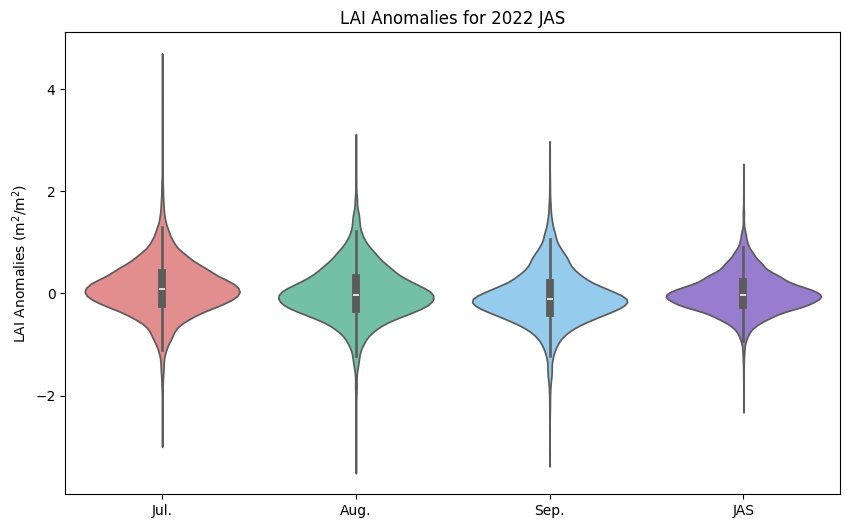

In [7]:
# import seaborn as sns

# data_to_plot = [box7, box8, box9, box789]
# custom_palette = ["lightcoral", "mediumaquamarine", "lightskyblue", "mediumpurple"]
# # Create a violin plot for all datasets in one figure
# plt.figure(figsize=(10, 6))
# sns.violinplot(data=data_to_plot, palette=custom_palette, inner='box')

# # Customize the plot as needed
# plt.title('LAI Anomalies for 2022 JAS')
# # plt.xlabel('Datasets')
# plt.ylabel('LAI Anomalies (m$^2$/m$^2$)')
# custom_labels = ['Jul.', 'Aug.', 'Sep.','JAS']
# plt.xticks(range(len(custom_labels)), custom_labels)
# # Show the plot
# plt.show()